<a href="https://colab.research.google.com/github/daisy-rivera/Sales-Predictions/blob/main/SalesPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sales Predictions

Daisy Rivera

The goal of this project is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales.

Link to original datasource [Here](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/)

##Import Libraries

In [12]:
# Pandas
import pandas as pd
# Numpy
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

## Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Regression Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

##Functions

In [13]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics for a model
def model_metrics(pipe, X_train, y_train, X_test, y_test, 
                       model_name='Regression Model', ):
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)
  
  metrics = ['train_MAE','test_MAE', 
             'train_RMSE', 'test_RMSE', 
             'train_R2', 'test_R2']
  
  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),7)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),7)

  ## Output Dataframe
  scores = pd.DataFrame(index=metrics, columns=[f'{model_name}_test'])
  scores.loc[metrics, f'{model_name}_test'] = [train_mae, test_mae,
                                               train_rmse, test_rmse,
                                               train_r2, test_r2]

  return scores

##Upload Data

In [14]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
filename = '/content/drive/MyDrive/Coding Dojo/Stack 2 - Machine Learning/06 Wk 6 Regression Models/sales_predictions (2).csv'
df = pd.read_csv(filename)

#Inspecting Data

In [16]:
#displaying first 5 rows
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
#checking datatypes, how many total rows and seeing if any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [18]:
#Total Number of rows and columns
df.shape

(8523, 12)

##Checking for duplicates

In [19]:
#Checking for duplicate items
df.duplicated().sum()

0

##Checking for inconsistencies in categories and their counts

In [20]:
#Checking for inconsistent categories of data
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [21]:
#Renaming all categories for consistency to Low Fat & Regular.
df.replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}, inplace = True)

In [22]:
#Verifying that the categories were changed.
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [23]:
#Checking for inconsistent categories of data
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [24]:
#Checking for inconsistent categories of data
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [25]:
#Checking for inconsistent categories of data
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [26]:
#Checking for inconsistent categories of data
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [27]:
#checking for inconsitent categories and count
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [28]:
#checking for inconsitent categories and count
#This column has large amount of unique values (will explore further)
df['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [29]:
#checking how many unique categories are there for Item Identifier
df['Item_Identifier'].describe()

count      8523
unique     1559
top       FDW13
freq         10
Name: Item_Identifier, dtype: object

Checking for any outliers or odd values in the data

In [30]:
#Summary statistics for the integer values.
df.describe().round(4)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.0000,8523.0000,8523.0000,8523.0000,8523.0000
mean,12.8576,0.0661,140.9928,1997.8319,2181.2889
std,4.6435,0.0516,62.2751,8.3718,1706.4996
min,4.5550,0.0000,31.2900,1985.0000,33.2900
25%,8.7738,0.0270,93.8265,1987.0000,834.2474
50%,12.6000,0.0539,143.0128,1999.0000,1794.3310
75%,16.8500,0.0946,185.6437,2004.0000,3101.2964
max,21.3500,0.3284,266.8884,2009.0000,13086.9648


##Types of Values

Numeric Values
- Item_Visibility
- Item_Weight (Will be addressing missing values using Mean weight value)
- Item_MRP
- Outlet_Establishment_Year

Ordinal Values
- Outlet_Location_Type (Tier1,Tier2,Tier3)

Nominal Values
- Item_Identifier (Will be dropping column due to high cardinality)                           
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size (This is Small, Medium and High but I will be filling missing items with a new Unknown category)
- Outlet_Type 




#Exploratory Data Analysis

###Correlation Heat Map

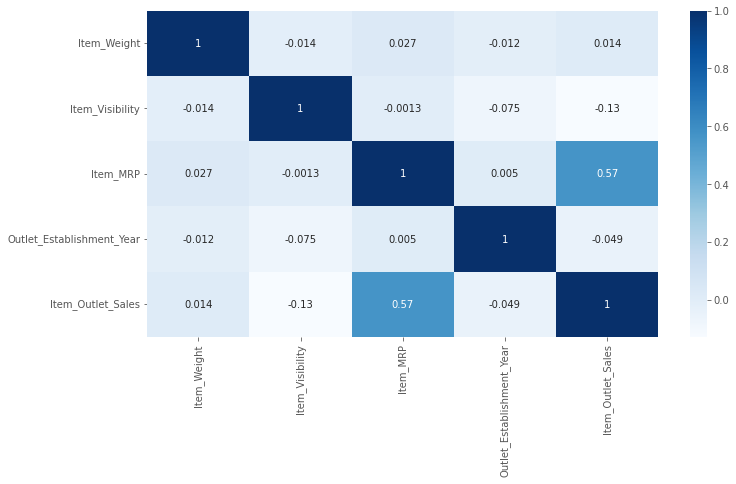

In [31]:
#creating a heat map
plt.style.use('ggplot')
plt.figure(figsize=(11.45,6))
sns.heatmap(df.corr(),annot=True,cmap='Blues');

From the Correlation Heatmap above the only decent correlation I see is between the Item_Outlet_Sales and the Item_MRP. Besides that their is pretty much no correlation between any of the other columns.

##Creating a graph to show Item Outlet Sales by Item Type

In [32]:
SalesbyItemType = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().round(2)
SalesbyItemType

Item_Type
Baking Goods             1952.97
Breads                   2204.13
Breakfast                2111.81
Canned                   2225.19
Dairy                    2232.54
Frozen Foods             2132.87
Fruits and Vegetables    2289.01
Hard Drinks              2139.22
Health and Hygiene       2010.00
Household                2258.78
Meat                     2158.98
Others                   1926.14
Seafood                  2326.07
Snack Foods              2277.32
Soft Drinks              2006.51
Starchy Foods            2374.33
Name: Item_Outlet_Sales, dtype: float64

In [33]:
SortedSalesbyItemType = SalesbyItemType.sort_values()

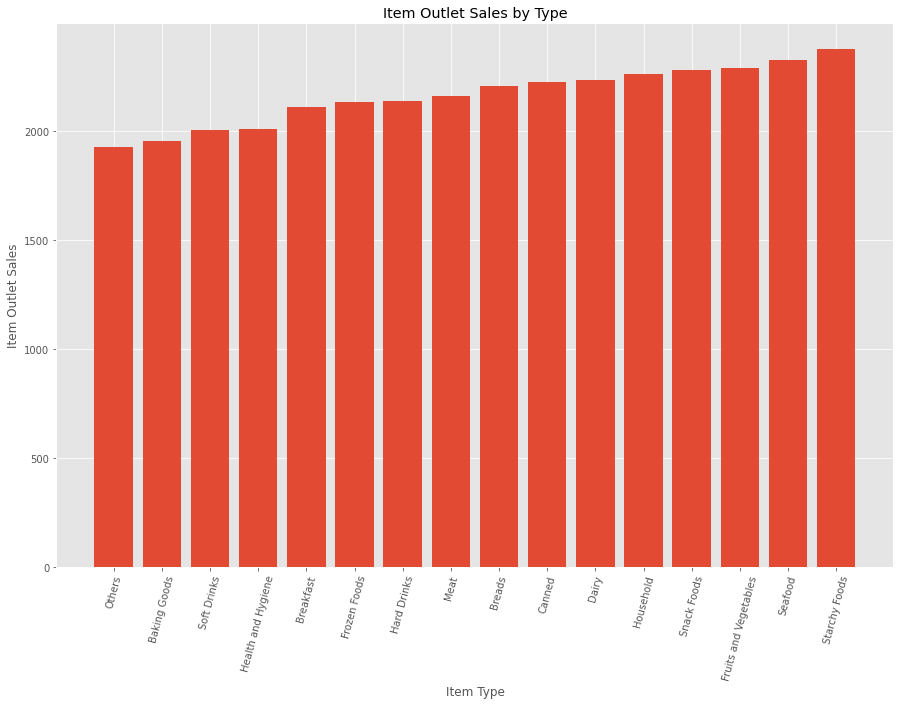

In [34]:
plt.figure(figsize=(15,10))
plt.bar(SortedSalesbyItemType.index, SortedSalesbyItemType.values)
plt.ylabel('Item Outlet Sales')
plt.xlabel('Item Type')
plt.title('Item Outlet Sales by Type')
plt.xticks(rotation=75);

Based on the graph above we know that the Starty Food Items have the most Outlet Sales and Others has the least sales. There isn't an item with overwhelmingly more sales in comparison to other items. Sales are pretty similar across the board.

##Creating a graph to show Item Outlet Sales by Outlet Type

In [35]:
SalesbyOutletType = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().round(2)
SalesbyOutletType

Outlet_Type
Grocery Store         339.83
Supermarket Type1    2316.18
Supermarket Type2    1995.50
Supermarket Type3    3694.04
Name: Item_Outlet_Sales, dtype: float64

In [36]:
SortedSalesbyOutletType = SalesbyOutletType.sort_values()

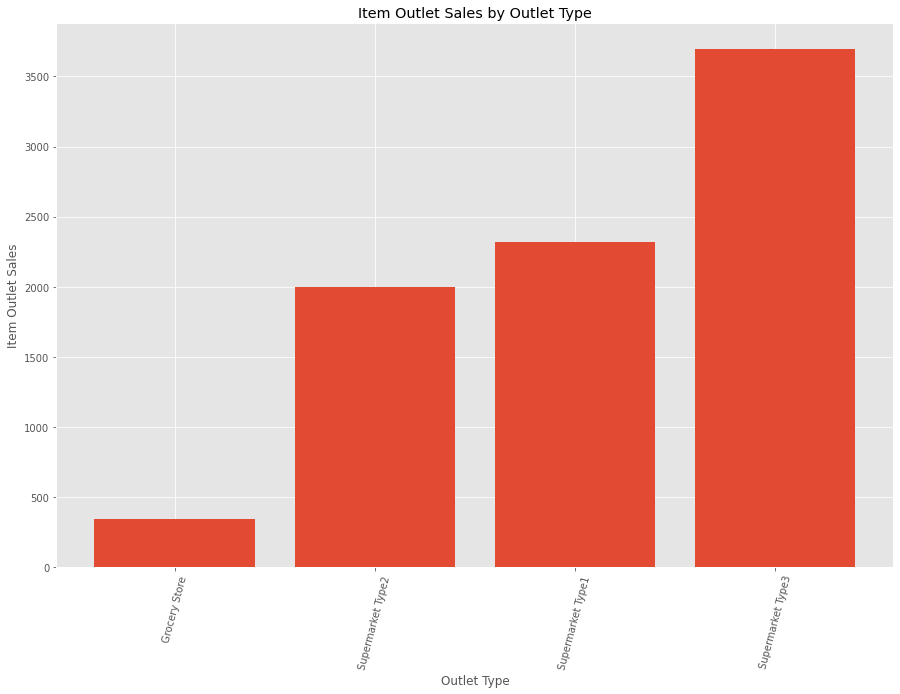

In [37]:
plt.figure(figsize=(15,10))
plt.bar(SortedSalesbyOutletType.index, SortedSalesbyOutletType.values)
plt.ylabel('Item Outlet Sales')
plt.xlabel('Outlet Type')
plt.title('Item Outlet Sales by Outlet Type')
plt.xticks(rotation=75);

I am seeing from the above graph that there is definitely a difference between the Outlet with the most and least sales. Supermarket Type 3 has the most Outlet Item Sales and Grocery Store has the least amount of Item Outlet Sales.

##Creating a Chart showing Sales grouped by both Item Types and the Item fat Content

In [38]:
Itemtypes = df.groupby(['Item_Type','Item_Fat_Content']).mean().reset_index()


In [39]:
Itemtypes = Itemtypes.sort_values(by = 'Item_Outlet_Sales')
Itemtypes[:5]

,Item_Type,Item_Fat_Content,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,Baking Goods,Low Fat,12.552996,0.066150,120.525869,1997.310030,1764.509636
25,Soft Drinks,Regular,11.228220,0.070315,121.771014,1997.802817,1854.065451
20,Seafood,Low Fat,13.805345,0.049211,113.508557,1997.189189,1907.786919
5,Breakfast,Regular,13.336182,0.082011,127.841304,1997.362319,1925.464652
19,Others,Low Fat,13.853285,0.060241,132.851430,1997.662722,1926.139702


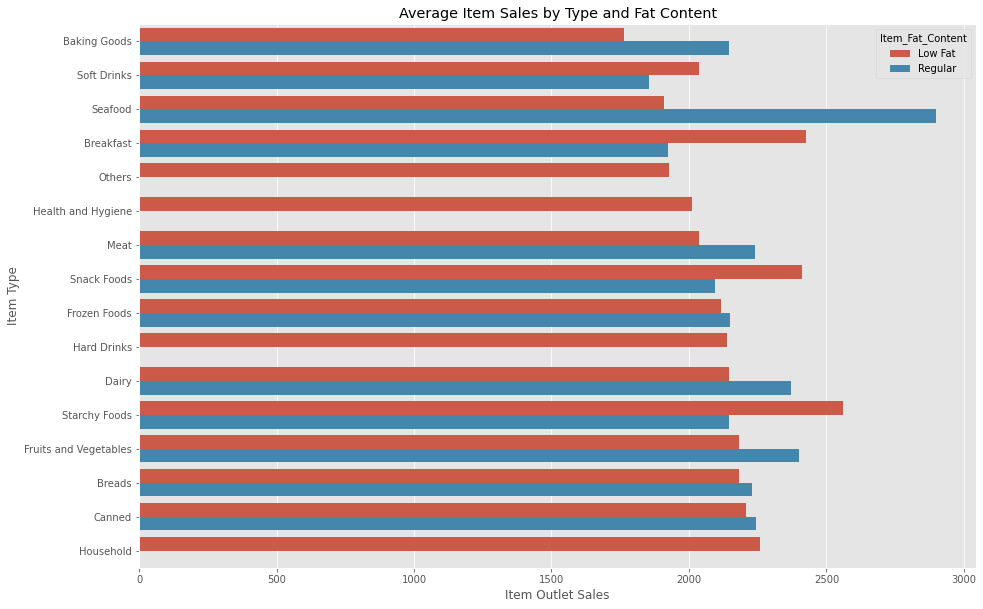

In [40]:
plt.figure(figsize=(15,10))
sns.barplot(data = Itemtypes, x = 'Item_Outlet_Sales', y = 'Item_Type', hue = 'Item_Fat_Content')
plt.title('Average Item Sales by Type and Fat Content')
plt.ylabel('Item Type')
plt.xlabel('Item Outlet Sales');

Item Outlet Sales sell more Low Fat items in the following categories:
- Soft Drinks
- Breakfast
- Snack Foods
-Starchy Foods

Item Outlet Sales sell more Regular items in the following categories:
- Baking Goods
- Seafood
- Mean
- Frozen Foods
- Dairy
- Fruits & Vegetables
- Breads
- Canned

The below items only have one category of items since they would fall outside of the what is considered Low Fat and Regular:
- Household
- Others
- Health & Hygiene
- Hard Drinks

#Preprocessing data for ML

Dropping irrevelant columns

In [41]:
#dropping Item_Identifier dut to high caridnality
df.drop(columns='Item_Identifier', inplace=True)

In [42]:
#verifying column was dropped
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

Addressing Ordinal Values

In [43]:
#checking category counts prior to converting
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [44]:
#replacing category values
df['Outlet_Location_Type'].replace({'Tier 1':0, 'Tier 2':1, 'Tier 3':2}, inplace=True)

#confirming changes were made
df['Outlet_Location_Type'].value_counts()

2    3350
1    2785
0    2388
Name: Outlet_Location_Type, dtype: int64

Verifying Missing Values

In [45]:
#Identifying missing values

df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

* I will address the missing items in the 'Item_Weight' column with a Mean SimpleImputer after splitting my data. 
* For 'Outlet_Size' I decided to add an 'Unknown' category since the amount of missing data (2410) is very similar to the counts of other categories.

##Assigning Target and Feature Values and Splitting Data into Traing & Test datasets

In [46]:
#Assign values to X and y
y = df['Item_Outlet_Sales']
X = df.drop(columns = 'Item_Outlet_Sales')

In [47]:
#split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##Creating Objects and Number Column lists

In [48]:
# Create column lists for objects and a number selector
cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

Instantiate Transformers

In [49]:
#instantiate the Transformers

#for categorical columns
constant_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

#for numerical columns
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

##Create Category and Numeric Pipelines

In [50]:
# Setup the pipelines for the numeric and categorical data
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(constant_imputer, ohe)

##Create Tuples to Pair Pipelines with Columns Selectors

In [51]:
num_tuple = (num_pipe, num_cols)
cat_tuple = (cat_pipe, cat_cols)

##Create Column Transformer

In [52]:
# Instantiate ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop')

#Linear Regression Model

In [53]:
#instantiate linear regression model
linreg = LinearRegression()

##Create Model Pipeline

In [54]:
# Combine preprocessor and linear regression model into a Pipeline
linreg_pipe = make_pipeline(preprocessor, linreg)
linreg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735640>)])),
                ('linearregression', LinearRegression())])

##Fit Model Pipeline on the training dataset for X and y

In [55]:
# Fit the model pipeline on the training data
linreg_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735640>)])),
                ('linearregression', LinearRegression())])

##Evaluating Model Performance

In [56]:
#evaluating model performance metrics using a function
linreg_scores = model_metrics(linreg_pipe, X_train, y_train, X_test, y_test, model_name='Linear Regression')

In [57]:
linreg_scores

,Linear Regression_test
train_MAE,847.1223
test_MAE,804.1111
train_RMSE,1139.1036
test_RMSE,1092.8592
train_R2,0.561555
test_R2,0.567107


#DecisionTree Model

###Instantiate DecisionTree Model

In [58]:
#instantiating regression tree model
dec_tree = DecisionTreeRegressor(random_state=42)

##Create Model Pipeline

In [59]:
# Combine preprocessor and decision tree model into a Pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
dec_tree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735640>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

##Fit Model Pipeline on the training dataset for X and y

In [60]:
# Fit the model pipeline on the training data
dec_tree_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735640>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

##Evaluate the DecisionTree Model

In [61]:
#evaluating model performance metrics using a function
model_metrics(dec_tree_pipe, X_train, y_train, X_test, y_test, model_name='Decision Tree')

,Decision Tree_test
train_MAE,0.0
test_MAE,1044.608
train_RMSE,0.0
test_RMSE,1499.3446
train_R2,1.0
test_R2,0.185193


This model is highly bias and highly correlated. Will try to make some improvements by tuning.

###Tuning the DecisionTree Model

In [62]:
#viewing available parametors for this model
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [63]:
#verify the decision tree depth
dec_tree.get_depth()

40

###Creating a loop to tune the model using the Max_Depth parameter

In [64]:
# List of values to try for max_depth:
depths = list(range(1, 41))

# Data frame to store the score for each value of max_depth:
dt_scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])

#for loop 
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
    dec_tree_pipe.fit(X_train, y_train)
    train_score = dec_tree_pipe.score(X_train, y_train)
    test_score = dec_tree_pipe.score(X_test, y_test)
    dt_scores.loc[depth, 'Train Score'] = train_score
    dt_scores.loc[depth, 'Test Score'] = test_score

In [65]:
#sorting the score results
dt_sorted_scores = dt_scores.sort_values(by='Test Score', ascending=False)

#displaying first 5 rows
dt_sorted_scores.head()

,Test Score,Train Score
5,0.59471,0.60394
4,0.584005,0.582625
6,0.582274,0.615161
7,0.57672,0.626843
8,0.558569,0.643832


 - Based on the trials using the Max_Depth parametor, our highest r2 score resulted from a depth of 5.

##Creating Final DecisionTree Model

###Instantiate and Fit the best DecisionTree Model

In [66]:
#instantiating final decision tree model with 
best_dt = DecisionTreeRegressor(random_state=42, max_depth=5)

#create decision tree pipeline
dec_tree_pipe2 = make_pipeline(preprocessor, best_dt)

#fit decision tree pipeline
dec_tree_pipe2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0be735640>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [67]:
#evaluating scores using function
decision_tree_scores = model_metrics(dec_tree_pipe2, X_train, y_train, X_test, y_test, model_name='Decision Tree')

In [68]:
#displaying scores
decision_tree_scores

,Decision Tree_test
train_MAE,762.6102
test_MAE,738.3173
train_RMSE,1082.6462
test_RMSE,1057.4431
train_R2,0.60394
test_R2,0.59471


In [69]:
#combining scores for both linear regression and decision tree models for better comparison
scores = pd.concat([decision_tree_scores, linreg_scores], axis=1)

In [70]:
#displaying combined scores
scores

,Decision Tree_test,Linear Regression_test
train_MAE,762.6102,847.1223
test_MAE,738.3173,804.1111
train_RMSE,1082.6462,1139.1036
test_RMSE,1057.4431,1092.8592
train_R2,0.60394,0.561555
test_R2,0.59471,0.567107


#Final Evaluation

Comparing both the Decision Tree and Linear Regression models, the Decision Tree Model performed better overall. I utilized various regression metrics and the Decision Tree out performed the in all metrics.

Although I was able to improve the Decision tree model in its prediction perfomance, I would hightly recommned gathering other relevant features that would help with Item Sales predictions. It can be concluded that this model has a high bias which would not be super reliable when making predictions.